In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from joblib import dump, load
import seaborn as sns


In [3]:
def preprocess_data(df):
    dfn = df.drop(df.columns[0:2], axis=1)
    dfn = dfn.dropna(axis=0)
    dfn = dfn.reset_index()
    
    dfc = dfn.copy()
    top_c = ['BRA', 'PRT', 'FRA', 'DEU', 'ITA', 'GBR', 'ESP', 'USA', 'NLD', 'CHE']
    dfc["new_nationality"] = dfc["Nationality"].apply(lambda x: x if x in top_c else "Other")
    dfc["has_not_appeared"] = np.where( (dfc["BookingsCheckedIn"] == 0) , 1, 0)
    drop_cols = ['index','Nationality','BookingsCanceled','BookingsNoShowed','BookingsCheckedIn']
    cat_cols = ["new_nationality","MarketSegment","DistributionChannel"]
    
    ohe = load('encoder.joblib')
    sc = load('scaler.joblib')
    
    encoded_train = ohe.transform(dfc[cat_cols]).toarray()
    
    ohdf = pd.DataFrame(encoded_train,columns = ohe.get_feature_names(cat_cols))
    
    combines_frames = [dfc,ohdf]
    dfc = pd.concat(combines_frames,axis=1)

    dfc = dfc.drop(drop_cols,axis=1)
    dfc = dfc.drop(cat_cols,axis=1)
    
    X = dfc.drop("has_not_appeared",axis=1)
    y = dfc["has_not_appeared"]
    y = pd.get_dummies(y).values

    X = sc.transform(X)
    
    return X, y

In [4]:
df = pd.read_csv('./test.csv')
X, y = preprocess_data(df)

In [5]:
model = tf.keras.models.load_model('nn/')
results = model.predict(X)
pred_val = [x.argmax() for x in results]
true_vals = [i.argmax() for i in y]

cm_data = confusion_matrix(true_vals,pred_val)


In [8]:
cm_data

array([[468,   4],
       [  0, 495]], dtype=int64)

<AxesSubplot:>

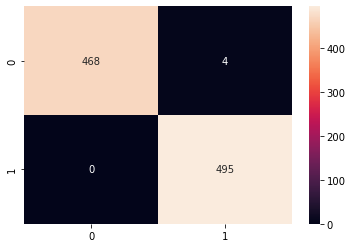

In [10]:
sns.heatmap(cm_data, annot=True, fmt='g')